In [460]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.ensemble import RandomForestRegressor
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [428]:
industry = ['801750.SI', '801740.SI', '801080.SI', '801120.SI', '801150.SI']
industry = ['801750.SI']
industry = ['801750.SI', '801740.SI', '801080.SI',]
#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'vol',
                                 'amount',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'dv_ttm',
                                 'total_mv'])

money_dic = DP.get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [429]:
st = DP.get_st_data(industrys, industry, data['open'])

In [430]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

vol = data['vol']
amount = data['amount']

vwap = (amount / vol * data['adj_factor']).fillna(method='ffill')
vwap = np.log(vwap)

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

dv = data['dv_ttm']

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [431]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [432]:
n = 2
#y = standardize_industry(OPEN.shift(-n)-OPEN, industrys, industry)
y = standardize_industry(CLOSE.shift(-n+1)-OPEN, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [672]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(1).sum().shift(1), industrys, industry)
x3 = standardize_industry(r_rinei.rolling(3).sum().shift(2), industrys, industry)
x4 = standardize_industry(r_rinei.rolling(5).sum().shift(5), industrys, industry)
x5 = standardize_industry(r_rinei.rolling(10).sum().shift(10), industrys, industry)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye.rolling(1).sum().shift(1), industrys, industry)
z3 = standardize_industry(r_geye.rolling(3).sum().shift(2), industrys, industry)
z4 = standardize_industry(r_geye.rolling(5).sum().shift(5), industrys, industry)
z5 = standardize_industry(r_geye.rolling(10).sum().shift(10), industrys, industry)

m1 = standardize_industry(CLOSE/CLOSE.rolling(3).mean(), industrys, industry)
m2 = standardize_industry(CLOSE/CLOSE.rolling(5).mean(), industrys, industry)
m3 = standardize_industry(CLOSE/CLOSE.rolling(10).mean(), industrys, industry)
m4 = standardize_industry(CLOSE/CLOSE.rolling(20).mean(), industrys, industry)
m5 = standardize_industry(CLOSE/CLOSE.rolling(40).mean(), industrys, industry)

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh.rolling(1).sum().shift(1), industrys, industry)
h3 = standardize_industry(rh.rolling(3).sum().shift(2), industrys, industry)
h4 = standardize_industry(rh.rolling(5).sum().shift(5), industrys, industry)
h5 = standardize_industry(rh.rolling(10).sum().shift(10), industrys, industry)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl.rolling(1).sum().shift(1), industrys, industry)
l3 = standardize_industry(rl.rolling(3).sum().shift(2), industrys, industry)
l4 = standardize_industry(rl.rolling(5).sum().shift(5), industrys, industry)
l5 = standardize_industry(rl.rolling(10).sum().shift(10), industrys, industry)

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr.rolling(1).sum().shift(1), industrys, industry)
vr3 = standardize_industry(vr.rolling(3).sum().shift(2), industrys, industry)
vr4 = standardize_industry(vr.rolling(5).sum().shift(5), industrys, industry)
vr5 = standardize_industry(vr.rolling(10).sum().shift(10), industrys, industry)


rzrq1 = standardize_industry(d_rzrq, industrys, industry).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(1).sum().shift(1), industrys, industry).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(3).sum().shift(2), industrys, industry).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(5).sum().shift(5), industrys, industry).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(10).sum().shift(10), industrys, industry).fillna(0)

gt1 = standardize_industry(d_gt, industrys, industry).fillna(0)
gt2 = standardize_industry(d_gt.rolling(1).sum().shift(1), industrys, industry).fillna(0)
gt3 = standardize_industry(d_gt.rolling(3).sum().shift(2), industrys, industry).fillna(0)
gt4 = standardize_industry(d_gt.rolling(5).sum().shift(5), industrys, industry).fillna(0)
gt5 = standardize_industry(d_gt.rolling(10).sum().shift(10), industrys, industry).fillna(0)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

lmv = standardize_industry(lmv, industrys, industry)

ao1 = standardize_industry(vwap-OPEN, industrys, industry)
ao2 = standardize_industry((vwap-OPEN).shift(), industrys, industry)
ca1 = standardize_industry(CLOSE-vwap, industrys, industry)
ca2 = standardize_industry((CLOSE-vwap).shift(), industrys, industry)

dv = standardize_industry(dv, industrys, industry)

rv1 = standardize_industry(r1 * ltrf, industrys, industry)

In [723]:
r_market = ror.mean(1)
#回归天数
n_reg = 10
tmp = [{k:ror.loc[:, industrys[i]].mean(1) for k in industrys[i]} for i in industry]
tmp1 = {}
for d in tmp:
    tmp1.update(d)

def reg(y, x, n):
    lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
    lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
    b = lxy / lxx
    a = y.rolling(n).mean() - b * x.rolling(n).mean()
    
    return a, b

a, b = reg(DataFrame(ror), DataFrame(tmp1), n_reg)
e = DataFrame(ror) - a - b * DataFrame(tmp1)
a = standardize_industry(a, industrys, industry)
b = standardize_industry(b, industrys, industry)
std_e = standardize_industry(e.rolling(n_reg).std(), industrys, industry)
#b = (n_reg * ror.rolling(n_reg).mean().mul(r_market.rolling(n_reg).mean(), 0) - (ror.mul(r_market, 0)).rolling(n_reg).sum()) / (n_reg * ror.rolling(n_reg).mean()**2 - (ror**2).rolling(n_reg).sum())
#a = (-b * ror.rolling(n_reg).mean()).add(r_market.rolling(n_reg).mean(), 0)

In [724]:
n_zhichengzuli = 10
HH = HIGH.rolling(n_zhichengzuli).max()
LL = LOW.rolling(n_zhichengzuli).min()
w = (CLOSE - LL) / (HH - LL)
w = standardize_industry(w, industrys, industry)
w.fillna(0, inplace=True)

In [809]:
n_m = 10
sk = ror.rolling(n_m).skew()
ku = ror.rolling(n_m).kurt()
sk = standardize_industry(sk, industrys, industry)
ku = standardize_industry(ku, industrys, industry)

In [810]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5,#没啥用
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,#多余
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,#估计没ch好用
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,#同下
    'ch1':ch1, 'ch2':ch2, 'ch3':ch3, 'ch4':ch4, 'ch5':ch5,#试试看
    'cl1':cl1, 'cl2':cl2, 'cl3':cl3, 'cl4':cl4, 'cl5':cl5,#试试看
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,#逻辑不好
    'ao1':ao1, 'ao2':ao2,
    'ca1':ca1, 'ca2':ca2,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rv1':rv1,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps,
    'dv':dv,
    'lmv':lmv,
    'a':a, 'b':b, 'std_e':std_e,
    'w':w,
    'sk':sk, 'ku':ku,
}

In [811]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = 0
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

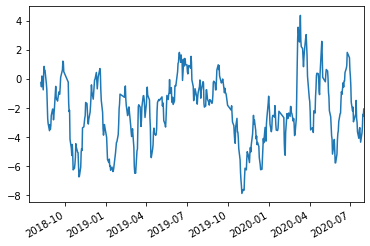

In [812]:
ic, ir = tools.icir(ku.shift().iloc[-500:,:], y.iloc[-500:,:], n=20, rank=True)
ic.rolling(20).mean().plot()

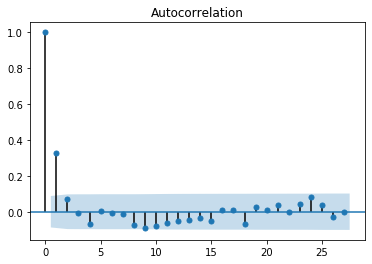

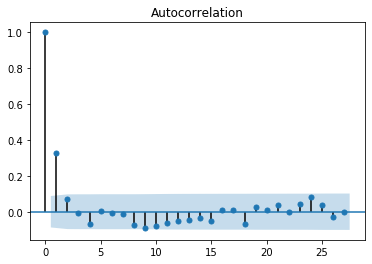

In [813]:
statsmodels.graphics.tsaplots.plot_acf(ic)

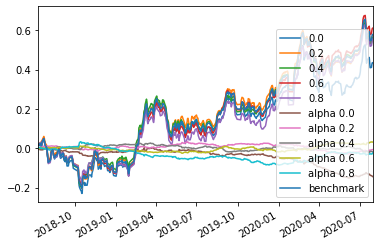

In [816]:
tools.group_backtest((sk).shift().iloc[-500:,:], ((CLOSE.shift(-n+1)-OPEN) / n).iloc[-500:,:], n=5)

In [818]:
begin_date = '2017-01-01'
split_date = '2019-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [819]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [841]:
model = smf.ols('y~ca1\
                  +a+b+std_e\
                  +z1\
                  +m3\
                  +w\
                  +rv1\
                  +pe\
                  +vr1\
                  +lmv\
                  +gt1\
                  +sk+ku\
                  ', data=df_train).fit()
model.tvalues

Intercept    -6.205689
ca1         -18.605507
a            -2.636969
b            13.418027
std_e        -3.617828
z1           -5.099847
m3           -4.620305
w             7.030757
rv1           5.361574
pe            6.409557
vr1           3.382220
lmv          -4.174878
gt1           3.177950
sk            1.757502
ku           -3.792833
dtype: float64

002766.SZ    0.184241
603660.SH    0.166670
300600.SZ    0.140503
002217.SZ    0.139002
300730.SZ    0.138910
300150.SZ    0.126246
000662.SZ    0.122438
002288.SZ    0.114605
300550.SZ    0.110130
300462.SZ    0.107676
Name: 2018-12-28 00:00:00, dtype: float64


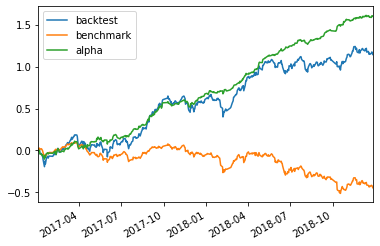

In [842]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.98
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300303.SZ    0.151697
300657.SZ    0.139472
600765.SH    0.114858
002885.SZ    0.113924
300227.SZ    0.102024
000738.SZ    0.101079
603678.SH    0.099629
300625.SZ    0.097920
300663.SZ    0.097564
300462.SZ    0.094937
Name: 2020-07-31 00:00:00, dtype: float64


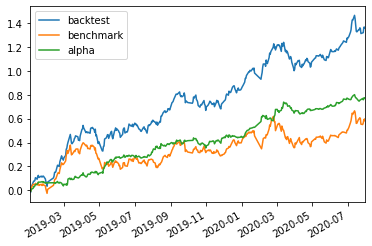

In [843]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.98
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [641]:
ror_huice.mean(1).iloc[-15:]

2020-07-13    0.035085
2020-07-14   -0.019383
2020-07-15   -0.048139
2020-07-16   -0.050202
2020-07-17   -0.007861
2020-07-20    0.028997
2020-07-21   -0.007809
2020-07-22    0.022296
2020-07-23    0.009515
2020-07-24   -0.049276
2020-07-27    0.002137
2020-07-28    0.000069
2020-07-29    0.036275
2020-07-30   -0.028916
2020-07-31    0.015701
dtype: float64

In [414]:
position.sum(1)

2018-01-02    0
2018-01-03    3
2018-01-04    3
2018-01-05    3
2018-01-08    3
             ..
2020-07-27    3
2020-07-28    3
2020-07-29    3
2020-07-30    3
2020-07-31    3
Length: 627, dtype: int64

In [35]:
#((ror_huice).mean(1)-0.0007+1).cumprod().plot()

In [36]:
ror_huice.mean(1).mean() / ror_huice.mean(1).std() * np.sqrt(len(ror_huice))

2.4887268226920445

In [927]:
#(benchmark.mean(1)+1).cumprod().plot()

In [1108]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300227.SZ    0.142833
002885.SZ    0.134738
002417.SZ    0.134002
300303.SZ    0.129450
300625.SZ    0.125569
300479.SZ    0.114250
300462.SZ    0.097601
603636.SH    0.087639
300657.SZ    0.086552
300556.SZ    0.081536
Name: 2020-07-30 00:00:00, dtype: float64


In [1109]:
print(y_hat2.iloc[-2,:].sort_values(ascending=False).dropna().iloc[:10])

300227.SZ    0.156490
002664.SZ    0.106134
603303.SH    0.089545
300775.SZ    0.082711
300650.SZ    0.077913
600850.SH    0.077593
002922.SZ    0.077363
300605.SZ    0.074249
300600.SZ    0.073699
300032.SZ    0.072268
Name: 2020-07-29 00:00:00, dtype: float64


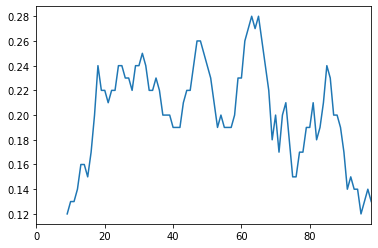

In [930]:
Series([len(y_hat2.iloc[-i,:].sort_values(ascending=False).dropna().iloc[:10].index & y_hat2.iloc[-i-1,:].sort_values(ascending=False).dropna().iloc[:10].index)/10 for i in range(1,100)]).rolling(10).mean().plot()

In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [386]:
Series([1,2,3]).rename('1').name

'1'

In [387]:
factor = DataFrame(np.arange(12).reshape(3,4))

In [404]:
factor.apply(lambda a:Series(rankdata(a)), axis=1)

,0,1,2,3
0,4.0,1.0,2.0,3.0
1,1.0,2.0,3.0,4.0
2,1.0,2.0,3.0,4.0


In [390]:
factor.iloc[0,0] = 100

In [393]:
factor

,0,1,2,3
0,100,1,2,3
1,4,5,6,7
2,8,9,10,11


In [398]:
a=[200, 1,2,3]

In [399]:
sorted(range(len(a)), key = a.__getitem__)

[1, 2, 3, 0]

In [400]:
from scipy.stats import rankdata

In [401]:
rankdata(a)

array([4., 1., 2., 3.])

In [403]:
rankdata(factor)

array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [409]:
s = Series([1,2]).rename(11)

In [410]:
DataFrame(s)

,11
0,1
1,2


In [622]:
df = DataFrame(np.arange(12).reshape(3,4))

In [623]:
df2 = df + 1

In [627]:
df2.divide(df)

,0,1,2,3
0,inf,2.000000,1.500000,1.333333
1,1.250,1.200000,1.166667,1.142857
2,1.125,1.111111,1.100000,1.090909


In [671]:
df = pro.us_basic()

In [672]:
df

,ts_code,name,classify,list_date,delist_date
0,ONCY,None,EQT,20011005,None
1,SCCO,None,EQT,19950124,None
2,KAOCF,None,EQT,19740319,None
3,BOIRF,None,EQT,19880628,None
4,SDXOF,None,EQT,19830304,None
...,...,...,...,...,...
5995,ESESQ,None,EQT,20031014,None
5996,TRKX,None,EQT,20000718,None
5997,ELAMF,None,EQT,19960320,None
5998,CZNB,None,EQT,20120724,None


In [680]:
O = DataFrame()
C = DataFrame()
for stock in df.ts_code:
    tmp = pro.us_daily(ts_code=stock, start_date='20100101', end_date='20200101').set_index('trade_date')
    time.sleep(30)
    O.loc[:,stock] = tmp.open
    C.loc[:,stock] = tmp.close

KeyboardInterrupt: 

In [689]:
C.fillna(method='ffill')

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,4.76,42.48,NaN,NaN,NaN,NaN,0.55,0.08,0.00,NaN,...,0.00,1.66,NaN,NaN,NaN,92.55,2.50,NaN,8.03,27.50
20191230,3.87,42.49,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,NaN,NaN,NaN,92.44,2.77,NaN,7.81,27.50
20191227,2.84,42.57,NaN,NaN,NaN,NaN,0.40,0.08,0.00,NaN,...,0.00,1.65,23.13,NaN,NaN,93.00,2.70,NaN,7.92,27.50
20191226,2.82,43.19,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.69,22.33,NaN,NaN,92.87,2.70,NaN,8.01,27.50
20191224,1.83,42.59,NaN,NaN,NaN,NaN,0.40,0.09,0.00,NaN,...,0.00,1.70,22.99,NaN,NaN,92.19,2.51,NaN,8.29,27.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,2.94,36.26,24.74,45.9,58.48,1.64,0.47,0.34,0.64,2.85,...,0.02,7.34,18.74,0.0,NaN,108.48,3.25,0.2,4.95,16.50
20100107,2.87,35.56,24.74,45.9,58.15,1.64,0.47,0.34,0.64,2.85,...,0.02,7.43,18.73,0.0,NaN,108.14,3.25,0.2,4.88,16.50
20100106,2.92,35.90,24.74,45.9,60.23,1.64,0.47,0.34,0.63,2.85,...,0.02,7.05,18.45,0.0,NaN,105.27,3.25,0.2,4.94,15.05


In [695]:
O=O.sort_index()
C=C.sort_index()

In [717]:
rgeye=(O/C.shift()-1).fillna(0)
rgeye[rgeye==np.inf]=0
rgeye[rgeye>5]=0
rgeye[rgeye<-5]=0

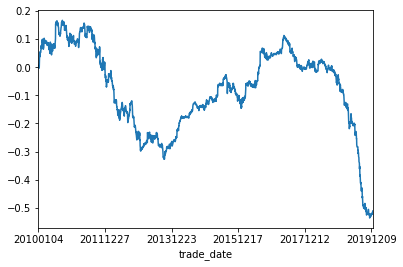

In [718]:
rgeye.mean(1).cumsum().plot()

In [704]:
rgeye.max()

ONCY     9.189189
SCCO     0.050389
KAOCF    0.048622
BOIRF    0.025781
SDXOF    0.113889
           ...   
ICE      0.058221
AQSP     1.750000
YHDT     1.352941
OSUR     0.214545
PSBQ     0.166667
Length: 77, dtype: float64

In [688]:
rgeye

,ONCY,SCCO,KAOCF,BOIRF,SDXOF,ODMUF,CHJHF,DBOXF,IMNPQ,CYUFF,...,ABCE,BWEN,PYT,ICBT,HOSZY,ICE,AQSP,YHDT,OSUR,PSBQ
trade_date,,,,,,,,,,,,,,,,,,,,,
20191231,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0.000000,0.000000
20191230,-0.399160,0.002119,0.0,0.0,0.000000,0.0,-0.272727,-0.125,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0,0.005727,0.108000,0.0,-0.012453,-0.014182
20191227,-0.320413,0.020946,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.024242,0.000000,0.0,0,0.006166,-0.025271,0.0,0.029449,-0.007273
20191226,-0.348592,0.004933,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.042424,-0.009511,0.0,0,-0.005806,0.000000,0.0,0.049242,0.000000
20191224,-0.375887,-0.009030,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.0,...,0.0,0.029586,0.029557,0.0,0,-0.005061,0.125926,0.0,0.049938,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20100108,-0.003436,-0.019559,0.0,0.0,0.000000,0.0,0.000000,0.000,-0.247059,0.0,...,0.0,0.031989,0.005365,0.0,0,-0.007281,0.000000,0.0,-0.043222,0.000000
20100107,-0.013605,-0.015168,0.0,0.0,-0.005643,0.0,0.000000,0.000,0.000000,0.0,...,0.0,-0.038147,-0.012807,0.0,0,-0.034200,0.000000,0.0,0.000000,0.000000
20100106,0.020906,-0.014904,0.0,0.0,0.037317,0.0,0.000000,0.000,-0.031250,0.0,...,0.0,0.014805,-0.034170,0.0,0,-0.008692,0.000000,0.0,0.043033,0.000000


In [635]:
df = DataFrame(np.arange(12).reshape(3, 4))

In [640]:
df2 = df + 1
df.iloc[-1,-1] = 0

In [641]:
df.iloc[-6:,:].corrwith(df2.iloc[-6:,:])

0    1.000000
1    1.000000
2    1.000000
3   -0.427121
dtype: float64

In [273]:
gt1.apply(lambda x:(np.abs(x)>1e-6).any())

000066.SZ    True
000977.SZ    True
002063.SZ    True
002152.SZ    True
002153.SZ    True
             ... 
603976.SH    True
002923.SZ    True
002898.SZ    True
002880.SZ    True
300725.SZ    True
Length: 932, dtype: bool

In [274]:
gt1.sum()

000066.SZ      3.058870
000977.SZ      1.247908
002063.SZ     16.045800
002152.SZ    -29.453465
002153.SZ     -5.858971
                ...    
603976.SH    -46.050127
002923.SZ    -46.050127
002898.SZ    -46.050127
002880.SZ    -20.518216
300725.SZ    102.406118
Length: 932, dtype: float64

In [281]:
gt.notna().any()

000066.SZ     True
000977.SZ     True
002063.SZ     True
002152.SZ     True
002153.SZ     True
             ...  
603976.SH    False
002923.SZ    False
002898.SZ    False
002880.SZ     True
300725.SZ     True
Length: 932, dtype: bool